# Exploratory Data Analysis

## Imports

In [279]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

import os
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as tfk

from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import mse

from preprocessing.preprocessor import Preprocessor
from rnn.network import Network
from rnn.visualization import visualize_forecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load data

In [4]:
train: pd.DataFrame = pd.read_csv('data/no1_train.csv')
train.set_index('start_time', inplace=True)
test: pd.DataFrame = pd.read_csv('data/no1_validation.csv')
test.set_index('start_time', inplace=True)

y = train.pop('y')

# insert column with insert(location, column_name, column_value)

train.insert(0, 'y', y)


train.head()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,341.330021,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:15:00,330.114330,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:20:00,323.877221,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:25:00,296.438463,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:30:00,269.097132,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4


In [5]:
train.describe()


,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
count,225088.000000,225088.000000,225088.000000,225088.000000,225088.000000,225088.0,225088.000000,225088.000000,225088.000000
mean,8.907921,1888.334127,224.189826,21.803497,55.703266,0.0,2190.031963,-8.284305,-1999.055081
std,320.262539,401.000305,58.559855,3.579229,47.053033,0.0,444.077730,43.748315,1311.682286
min,-1579.680903,683.438000,80.371000,0.000000,0.000000,0.0,849.732000,-828.000000,-5541.200000
25%,-142.226700,1625.029000,185.017000,22.100000,15.704000,0.0,1916.523000,0.000000,-2996.700000
50%,-11.282351,1933.916000,225.938000,22.100000,41.848000,0.0,2248.874000,0.000000,-1953.700000
75%,127.454943,2175.595000,269.558000,24.100000,88.723000,0.0,2497.792000,0.000000,-906.900000
max,2956.333317,2995.524000,349.271000,25.700000,176.000000,0.0,3351.974000,474.000000,723.400000


## Data inspection

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

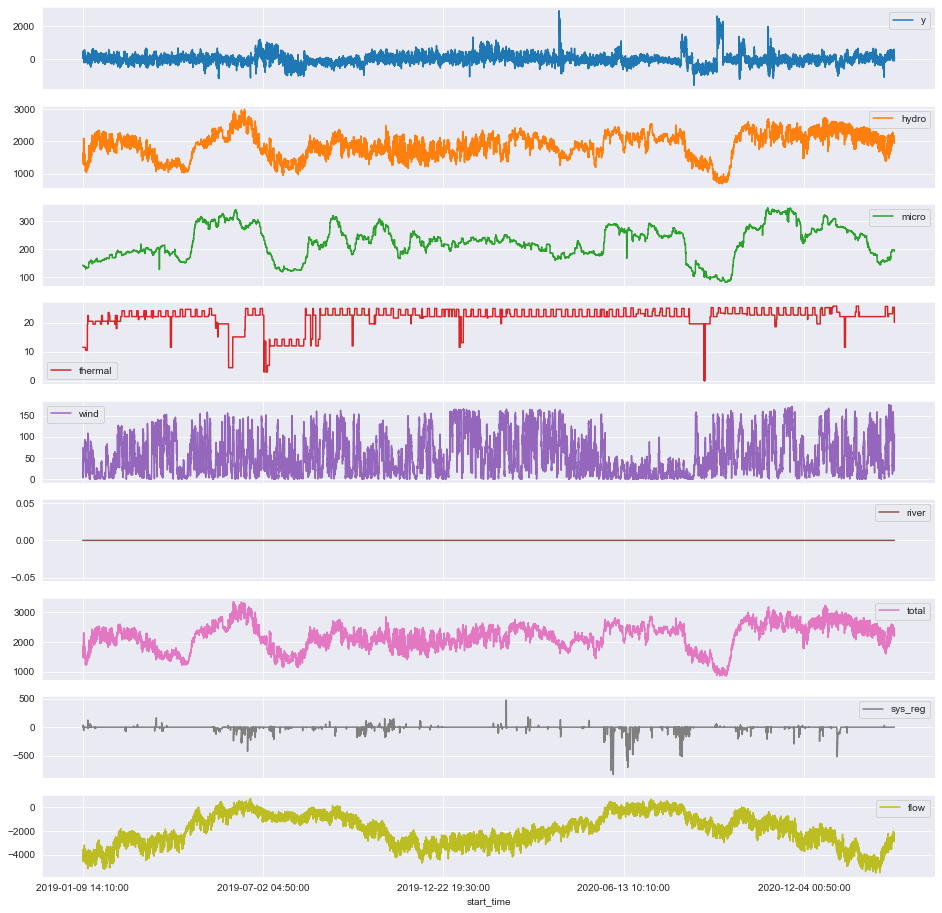

In [6]:
train.plot(subplots=True, figsize=(16,16))

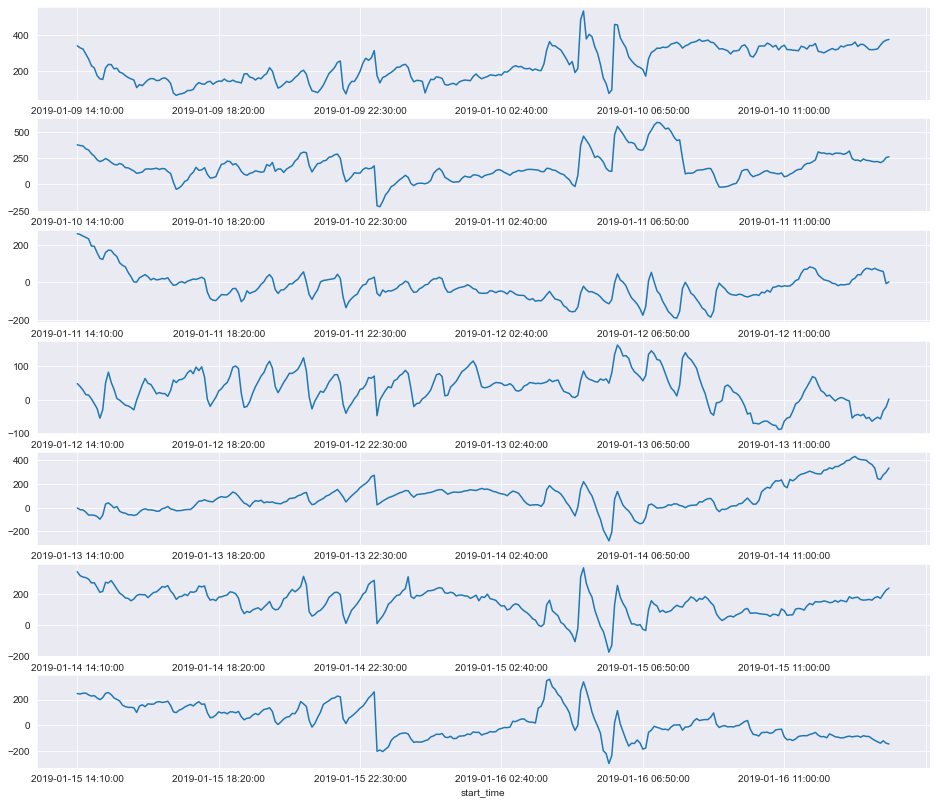

In [7]:
days = 7
fig, ax = plt.subplots(days, figsize=(16, days*2))
for day in range(days):
    train['y'][train.index[24*12*(day):24*12*(day+1)]].plot(ax=ax[day])
plt.show()

## Preprocessing

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

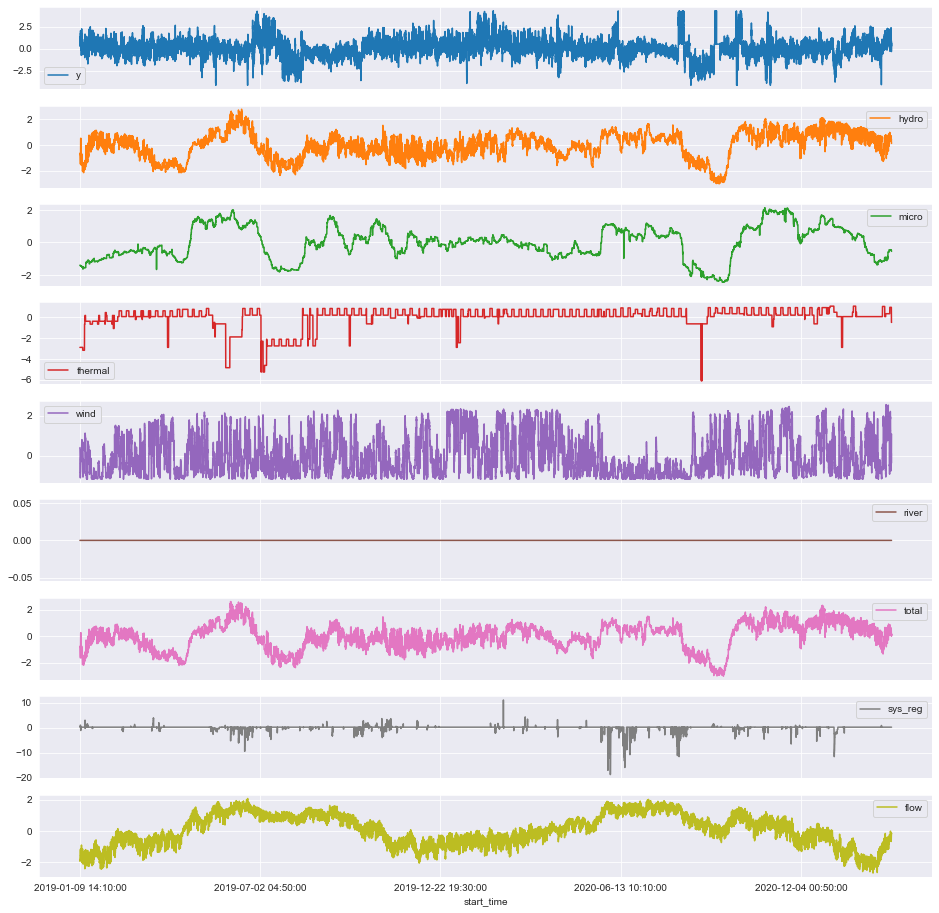

In [8]:
train_p = Preprocessor.pipeline(train, feature_engineering=False)
train_p.plot(subplots=True, figsize=(16,16))

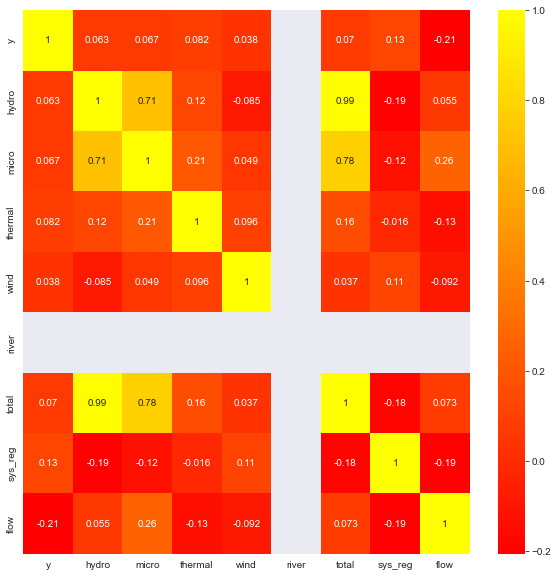

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(train_p.corr(), xticklabels=train_p.columns, yticklabels=train_p.columns, cmap='autumn', annot=True, ax=ax)
plt.show()

# Feature engineering

In [10]:
train_f = Preprocessor.pipeline(train_p, preprocessing=False)

In [11]:
train_f.head()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow,time_of_day_0,...,time_of_day_2,time_of_day_3,time_of_week,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,prev_y,prev_day_y,rolling_mean
start_time,,,,,,,,,,,,,,,,,,,,,
2019-01-10 14:10:00,1.433879,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.439464,1.307757,1.375215
2019-01-10 14:15:00,1.410102,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.433879,1.265605,1.402980
2019-01-10 14:20:00,1.396399,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.410102,1.242163,1.415471
2019-01-10 14:25:00,1.295119,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.396399,1.139039,1.399682
2019-01-10 14:30:00,1.250657,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.295119,1.036281,1.370937


In [12]:
print(train_f.index[0], train_f.index[24*12])

2019-01-10 14:10:00 2019-01-11 14:10:00


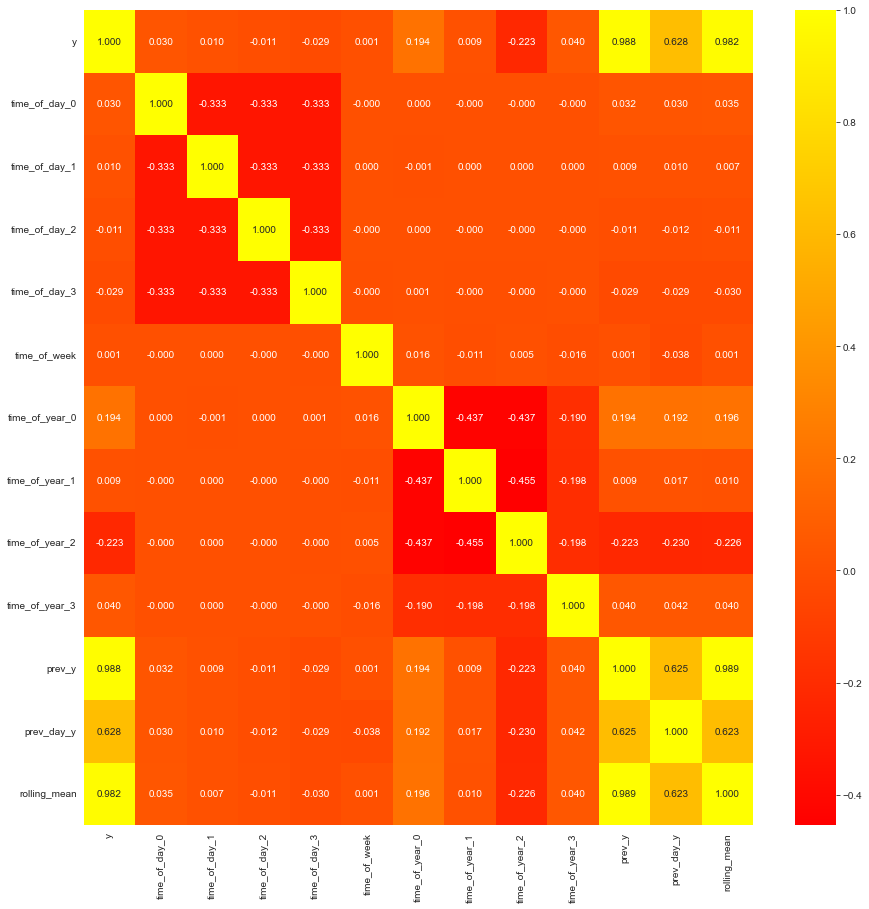

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
train_new = train_f.drop(columns=['hydro', 'micro', 'thermal', 'wind', 'river', 'total', 'sys_reg', 'flow'])
sns.heatmap(train_new.corr(), xticklabels=train_new.columns, yticklabels=train_new.columns, cmap='autumn', annot=True, ax=ax, fmt='.3f')
plt.show()

# Train RNN model

In [281]:
y = train_f['y']
x = train_f.drop(columns=['y', *[f'time_of_day_{i}' for i in range(4)], 'time_of_week', 'river'])

if isinstance(x, pd.Series):
    x = x.to_frame()

print(x.shape, type(x))
x.head()


(224800, 14) <class 'pandas.core.frame.DataFrame'>


,hydro,micro,thermal,wind,total,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,prev_y,prev_day_y,rolling_mean
start_time,,,,,,,,,,,,,,
2019-01-10 14:10:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.439464,1.307757,1.375215
2019-01-10 14:15:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.433879,1.265605,1.402980
2019-01-10 14:20:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.410102,1.242163,1.415471
2019-01-10 14:25:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.396399,1.139039,1.399682
2019-01-10 14:30:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.295119,1.036281,1.370937


In [282]:
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

logdir = os.path.join('logs', timestamp)
modeldir = os.path.join('models', timestamp)
tensorboard_callback = tfk.callbacks.TensorBoard(logdir, histogram_freq=1)
model_checkpoint_callback = tfk.callbacks.ModelCheckpoint(filepath=modeldir, save_weights_only=True)

sequence_length = 12*12
epochs = 200
learning_rate = 1e-3
decay = 1e-6
dropout_rate = 0.0
batch_size = 128

input_shape = (sequence_length, x.shape[1])
print(f'Input shape: {input_shape}')
net = Network(input_shape=input_shape,
              output_units=1, 
              hidden_units=[64, 128, 64], 
              dropout_rate=dropout_rate, 
              learning_rate=learning_rate,
              decay=decay)

net.fit(x, y, epochs=epochs, sequence_length=sequence_length, batch_size=batch_size, callbacks=[tensorboard_callback, model_checkpoint_callback])

Input shape: (144, 14)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 144, 64)           20224     
_________________________________________________________________
lstm_58 (LSTM)               (None, 144, 128)          98816     
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 168,513
Trainable params: 168,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1229/1229 [==============================] - 40s 30ms/step - loss: 0.1241 - val_loss: 0.1611
Epoch 2/200
1229/1229 [==============================] - 36s 29ms/step - loss: 0.0797 - val_loss: 0.0808
Epoch 3/200


In [344]:
test_f = Preprocessor.pipeline(test)
y_test = test_f['y']
x_test = test_f.drop(columns=['y', *[f'time_of_day_{i}' for i in range(4)], 'time_of_week', 'river'])

# Get missing columns in the training test
missing_cols = set(x.columns ) - set(x_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
x_test = x_test[x.columns]

print(x_test.shape)
x_test.head()

(27848, 14)


,hydro,micro,thermal,wind,total,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,prev_y,prev_day_y,rolling_mean
start_time,,,,,,,,,,,,,,
2021-03-02 03:30:00,-3.65496,-2.619516,0.873723,-1.23145,-3.773025,0.266162,-0.18119,1,0,0,0,1.189113,0.230203,1.108507
2021-03-02 03:35:00,-3.65496,-2.619516,0.873723,-1.23145,-3.773025,0.266162,-0.18119,1,0,0,0,0.797077,0.584744,0.999830
2021-03-02 03:40:00,-3.65496,-2.619516,0.873723,-1.23145,-3.773025,0.266162,-0.18119,1,0,0,0,0.641152,0.566769,0.923424
2021-03-02 03:45:00,-3.65496,-2.619516,0.873723,-1.23145,-3.773025,0.266162,-0.18119,1,0,0,0,0.714682,0.241843,0.801905
2021-03-02 03:50:00,-3.65496,-2.619516,0.873723,-1.23145,-3.773025,0.266162,-0.18119,1,0,0,0,0.496381,0.354180,0.659091


In [299]:
%tensorboard --logdir logs

Launching TensorBoard...

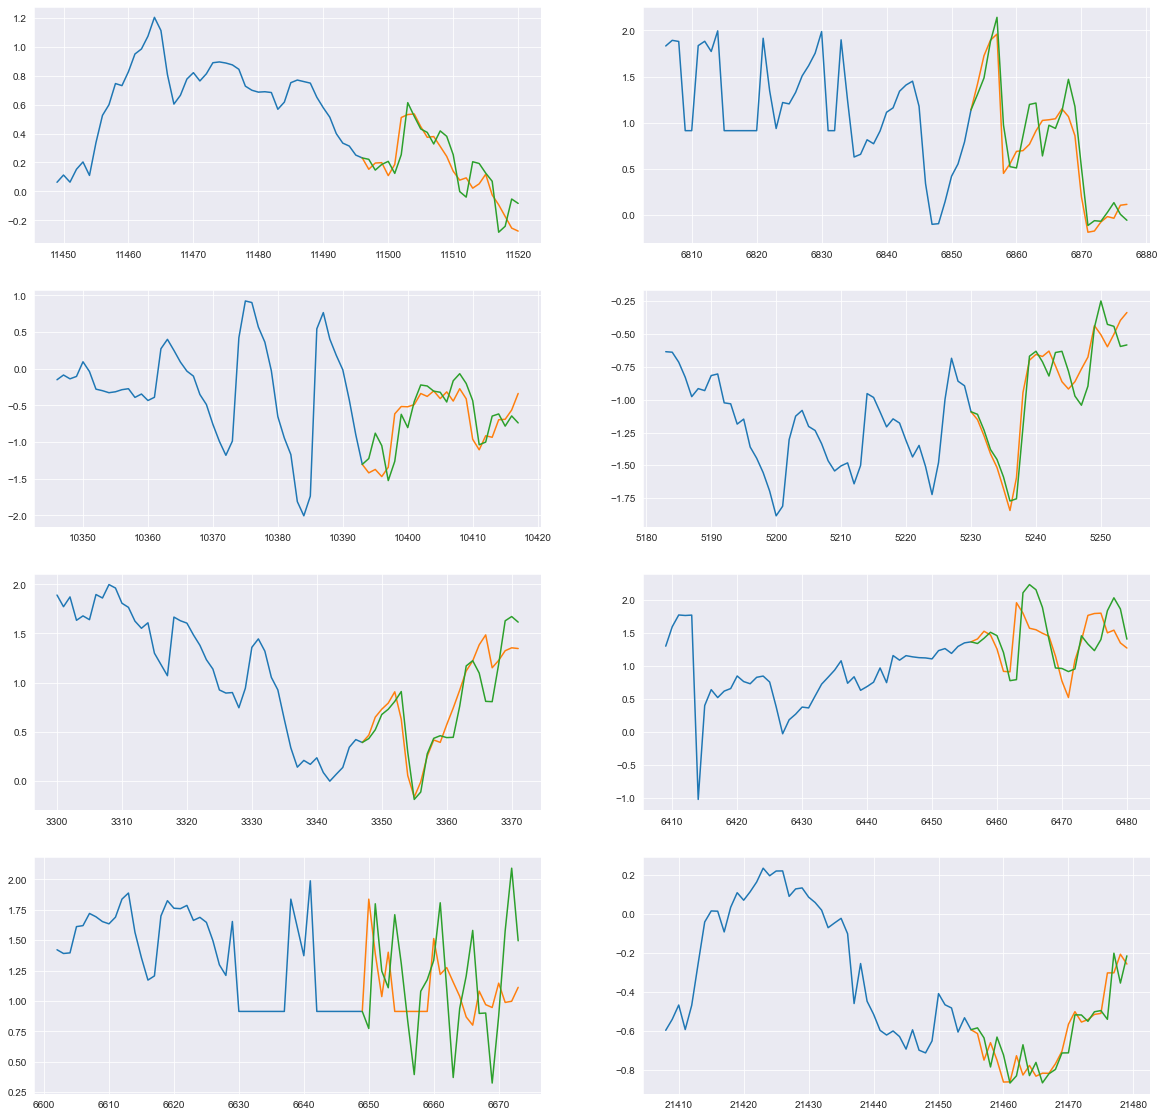

In [358]:
history_length = 12*4
forecast_steps = 24

rows = 4
cols = 2

fig, ax = plt.subplots(4, 2, figsize=(20, 20))

for r in range(rows):
    for c in range(cols):
        start_idx = np.random.randint(0, x_test.shape[0] - sequence_length)
        y_hat = net.multistep_predict(x_test, start_idx=start_idx, forecast_steps=forecast_steps)
        visualize_forecast(y_test, y_hat, ax[r][c], history_length=history_length, start_idx=start_idx, sequence_length=sequence_length)


plt.show()